## COSC 325 Final Project: Credit Card Fraud Analysis
### By "Regularly Scheduled Programming"
**Will Greenwood**&emsp;**Maddie Gross**&emsp;**Cinzia Pacione**&emsp;**Ethan Weathers**

### Import Dependencies

In [17]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from scipy import stats

import numpy as np

import seaborn

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn import metrics

from sklearn.metrics import mean_squared_error, r2_score

### Read and Clean Data
Add details later...

In [18]:
# Store csv in a pandas DataFrame
df = pd.read_csv("fraud_data.csv")

# Drop unused columns
drop_columns = []
if drop_columns:
    df.drop(columns=drop_columns, inplace=True)

# Verify there are no null values
null_count = df.isnull().sum()

# Convert selective columns to appropriate data types
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'],
                                             format='%d-%m-%Y %H:%M')
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')

#######################################################################
# We might not want to scale data if extreme values matter. idk :(
#######################################################################
# Scale numberical values with StandardScaler
# scaler_columns = ['amt', 'city_pop']
# scaler = StandardScaler()
# df[scaler_columns] = scaler.fit_transform(df[scaler_columns])


Optional cell to write metadata to a file:

In [19]:
show_metadata = False
if show_metadata:
    with open("metadata.txt", "w") as f:
        from io import StringIO
        
        buffer = StringIO()
        df.info(buf=buffer)
        f.write("DataFrame Info:\n")
        f.write(buffer.getvalue())
        
        f.write("\n\nNumber of unique values per column:\n")
        f.write(df.nunique().to_string())
        
        f.write("\n\nNull values per column:\n")
        f.write(null_count.to_string())

### Basic Statistics and Observations

Intro to this section...

Pie charts:

In [20]:
# Will

Histograms:

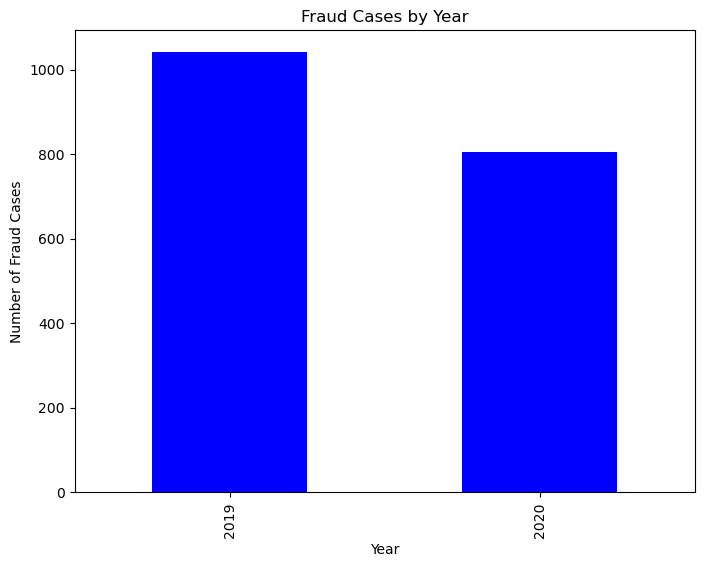

<function matplotlib.pyplot.show(close=None, block=None)>

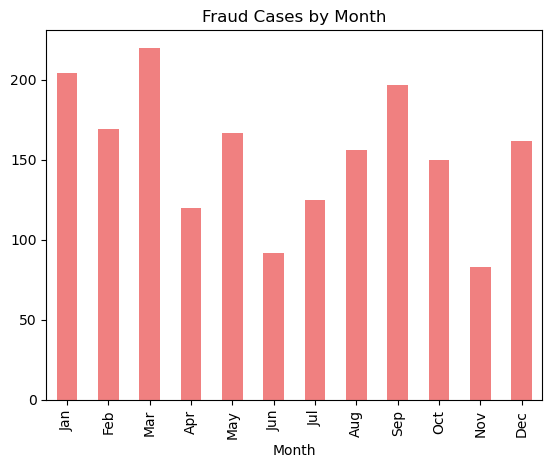

In [ ]:
# Ethan
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
fraud_df = df[df['is_fraud'] == 1]
fraud_by_month = fraud_df['month'].value_counts().sort_index()
fraud_by_year = fraud_df['year'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
fraud_by_year.plot(kind='bar', color='blue')
plt.title("Fraud Cases by Year")
plt.xlabel("Year")
plt.ylabel("Number of Fraud Cases")
plt.show()

fraud_by_month.plot(kind='bar', color='lightcoral')
plt.title("Fraud Cases by Month")
plt.xlabel("Month")
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show

Maps:

In [22]:
# Cinzia

Lists:

In [23]:
# Maddie

### Machine Learning :(

In [24]:
# code